# AI-Accelerated Academic Research

> **12 research sources analyzed in 82 seconds. Traditional literature review: hours. Our approach: minutes.**

## Transforming Literature Review with Batch Processing

**Research Question**: "What are the current approaches to AI model efficiency?"

**Challenge**: Analyzing multiple research sources (papers, videos, web content) typically requires separate API calls for each source-question combination, leading to redundant processing and high costs.

### The Token Economics Problem

When analyzing research literature, traditional approaches repeat content tokens for every question:

In [1]:
# Traditional approach - each question requires full content
sources = [
    "paper1.pdf",  # ~50,000 tokens
    "paper2.pdf",  # ~45,000 tokens
    "arxiv_url",  # ~40,000 tokens
    "youtube_video",  # ~200,000 tokens
]

questions = [
    "What are the main efficiency techniques?",
    "Which approaches show promising results?",
    "What are the research gaps?",
]

# Traditional: 3 calls x 335,000 tokens = 1,005,000 total tokens
# Batch: 1 call x 335,030 tokens = 3x fewer tokens

**Core problem**: Content dominates token usage but gets repeated unnecessarily.

### Batch Processing Solution

Process all questions simultaneously with content sent once:

In [2]:
# Batch approach:
# Single call: [All content] + [All questions] = ~335,000 + 30 tokens
# Efficiency improvement: ~3x (1,005,000 / 335,030)

We'll demonstrate cross-source synthesis with 66% cost reduction.

---

## Section 2: Multi-Source Setup & Analysis

### Content Sources

We'll analyze AI efficiency research from multiple source types:


In [3]:
# Import the framework (new API)
from types import SimpleNamespace as _NS

from dotenv import load_dotenv
from pydantic import BaseModel

from pollux import types
from pollux.config import resolve_config
from pollux.extensions.visualization import (
    create_focused_efficiency_visualization,
)
from pollux.frontdoor import run_synthesis
from pollux.research.efficiency import compare_efficiency

load_dotenv()
cfg = resolve_config()

# Define our research sources using explicit Source objects
_dir_sources = types.sources_from_directory("../cookbook/data/research_papers/")
_arxiv = types.Source.from_arxiv("https://arxiv.org/pdf/1503.02531")
_youtube = types.Source.from_youtube("https://www.youtube.com/watch?v=u1_K4UeAl-s")

sources = (*_dir_sources, _arxiv, _youtube)

# Summarize composition (replacement for old ContentAnalyzer)
breakdown = {}
for s in sources:
    breakdown[s.source_type] = breakdown.get(s.source_type, 0) + 1
content_summary = _NS(
    total_count=len(sources),
    breakdown=breakdown,
    traditional_api_calls=len(sources),  # naive: one call per source
)

print(f"📄 Total sources: {content_summary.total_count}")
print("📂 Source breakdown:")
for source_type, count in content_summary.breakdown.items():
    display_name = source_type.replace("_", " ").title()
    print(f"    • {display_name}: {count}")

📄 Total sources: 12
📂 Source breakdown:
    • File: 10
    • Arxiv: 1
    • Youtube: 1


### Efficiency Calculation

In [4]:
# Calculate theoretical efficiency
question_count = 8  # Number of research questions
traditional_calls = content_summary.traditional_api_calls  # sources x questions
batch_calls = 1

print(f"Traditional approach: {traditional_calls} API calls")
print(f"Batch approach: {batch_calls} API call")
print(f"Token efficiency potential: ~{question_count}x fewer tokens")
print(
    f"Cost reduction potential: ~{((question_count - 1) / question_count) * 100:.0f}%",
)

Traditional approach: 12 API calls
Batch approach: 1 API call
Token efficiency potential: ~8x fewer tokens
Cost reduction potential: ~88%


Automatic source counting enables precise efficiency calculation.

---

## Section 3: Batch Processing in Action

### Structured Output Schema

Define the research synthesis structure for reliable parsing:

In [5]:
class ResearchSynthesis(BaseModel):
    """Pydantic model for research synthesis."""

    executive_summary: str
    main_techniques: list[str]
    most_promising_approach: str
    research_gaps: list[str]
    future_directions: list[str]
    practical_recommendations: list[str]

### Research Questions

Cross-source synthesis questions that leverage multiple sources simultaneously:

In [6]:
synthesis_questions = [
    "What are the main efficiency techniques proposed across all sources?",
    "Create a comprehensive comparison of approaches and results across sources.",
    "What are the key trade-offs between accuracy and efficiency mentioned?",
    "Which approaches show the most promising results based on collective evidence?",
    "What gaps exist in current AI efficiency research based on these sources?",
    "What future research directions are suggested across all sources?",
    "Write a 400-word executive summary synthesizing key findings across all sources.",
    "What practical recommendations emerge for practitioners "
    "wanting to improve model efficiency?",
]

### Single API Call Processing

In [7]:
# Async synthesis using new API
import asyncio

from pollux.core.execution_options import make_execution_options

SYSTEM_INSTRUCTION = (
    "Provide focused, complete responses. For lists, include 3-5 key items."
)


async def _run_synthesis():
    # Enable remote file materialization so arXiv PDFs are downloaded and uploaded properly
    options = make_execution_options(remote_files_enabled=True)
    env = await run_synthesis(
        prompts=synthesis_questions,
        sources=sources,
        cfg=cfg,
        prefer_json=True,
        options=options,
    )
    # Parse first answer as ResearchSynthesis if JSON available; fallback to text
    ans = env.get("answers", [])
    text = ans[0] if ans else ""
    try:
        import json as _json

        data = _json.loads(text) if isinstance(text, str) else text
        synth = ResearchSynthesis(**data)
    except Exception:
        # Map text to minimal structure
        synth = ResearchSynthesis(
            executive_summary=str(text),
            main_techniques=[],
            most_promising_approach="",
            research_gaps=[],
            future_directions=[],
            practical_recommendations=[],
        )
    # Basic processing time from metrics if surfaced
    metrics = env.get("metrics", {})
    durations = metrics.get("durations", {}) if isinstance(metrics, dict) else {}
    processing_time = sum(
        float(v) for v in durations.values() if isinstance(v, (int, float))
    )
    return synth, float(processing_time or 0.0)


try:
    # If we're already in an event loop (e.g., Jupyter), avoid asyncio.run
    loop = asyncio.get_running_loop()
    try:
        import nest_asyncio  # type: ignore

        nest_asyncio.apply()
    except Exception:
        pass
    synthesis, processing_time = loop.run_until_complete(_run_synthesis())
except RuntimeError:
    # No running event loop
    synthesis, processing_time = asyncio.run(_run_synthesis())

print(
    f"✅ Analyzed {content_summary.total_count} sources in "
    f"{processing_time:.1f} seconds",
)

PipelineError: Error in handler 'APIHandler': Provider call failed: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '200'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '32s'}]}}

### Synthesis Results

In [ ]:
import textwrap


def wrap_text(text, width=80, indent=""):
    """Wrap text at word boundaries with optional indentation."""
    return textwrap.fill(
        text,
        width=width,
        initial_indent=indent,
        subsequent_indent=indent,
    )


print("🎯 CROSS-SOURCE SYNTHESIS RESULTS:")

print("Executive Summary:")
print(wrap_text(synthesis.executive_summary, width=80, indent="  "))

print("\nMain Techniques:")
for technique in synthesis.main_techniques[:5]:
    print(wrap_text(f"• {technique}", width=80, indent="  "))

print("\nMost Promising:")
print(wrap_text(synthesis.most_promising_approach, width=80, indent="  "))

print("\nResearch Gaps:")
for gap in synthesis.research_gaps[:3]:
    print(wrap_text(f"• {gap}", width=80, indent="  "))

🎯 CROSS-SOURCE SYNTHESIS RESULTS:
Executive Summary:
  Model efficiency in AI is becoming increasingly important due to the
  exponential increase in computational demands and limitations in hardware
  resources. Model-centric approaches such as pruning, quantization, and
  knowledge distillation help reduce model size, inference latency, and energy
  consumption. Pruning reduces the number of parameters; quantization reduces
  bit-width, and knowledge distillation transfers knowledge from larger models
  to smaller ones. However, a shift towards data-centric approaches, especially
  token compression, is crucial for handling the quadratic cost of self-
  attention over long token sequences. A promising future direction is the co-
  development of data and model-centric compression strategies to maximize
  overall efficiency. Researchers should explore non-traditional transformer
  architectures, study methods to accelerate and scale data-centric compression,
  and ensure that these te

The structured output ensures reliable data extraction and enables systematic analysis across diverse academic sources.

---

## Section 4: Efficiency Validation

> **Note**: The following comparison uses Gemini 2.0 Flash (free tier). Efficiency gains apply regardless of model choice, while synthesis quality scales with model capabilities.

### Actual vs Theoretical Comparison

Test with a reduced question set to measure real efficiency gains:


In [ ]:
# Subset for comparison (faster execution)
comparison_questions = [
    "What are the main efficiency techniques proposed across all sources?",
    "Which approaches show the most promising results based on collective evidence?",
    "What practical recommendations emerge for practitioners?",
]

# Compare vectorized vs naive using new research helper
import asyncio as _asyncio


async def _compare():
    options = make_execution_options(remote_files_enabled=True)
    report = await compare_efficiency(
        prompts=comparison_questions,
        sources=sources,
        cfg=cfg,
        options=options,
        prefer_json=True,
        include_pipeline_durations=True,
    )
    # Adapt to the visualization result shape used below
    results = {
        "metrics": {
            "individual": {
                "calls": int(report.naive_requests),
                "tokens": int(report.naive_tokens),
                "time": float(report.naive_time_s),
            },
            "batch": {
                "calls": int(report.vec_requests),
                "tokens": int(report.vec_tokens),
                "time": float(report.vec_time_s),
            },
        },
        "efficiency": {
            "token_efficiency_ratio": float(report.tokens_ratio),
            "time_efficiency": float(report.time_ratio),
            "meets_target": bool(report.tokens_ratio >= 3.0),
            "comparison_available": True,
        },
    }
    return results


try:
    # If already in an event loop (Jupyter), use existing loop
    loop = _asyncio.get_running_loop()
    try:
        import nest_asyncio  # type: ignore

        nest_asyncio.apply()
    except Exception:
        pass
    comparison_result = loop.run_until_complete(_compare())
except RuntimeError:
    # No running event loop
    comparison_result = _asyncio.run(_compare())

### Efficiency Metrics

📊 EFFICIENCY ANALYSIS:
Individual calls: 3
Batch calls: 1
Tokens - Individual: 846,281
Tokens - Batch: 282,104
Tokens saved: 564,177 (66.7% reduction)
Token efficiency: 3.0× improvement
Time efficiency: 3.7× improvement
Meets 3× target: ✅


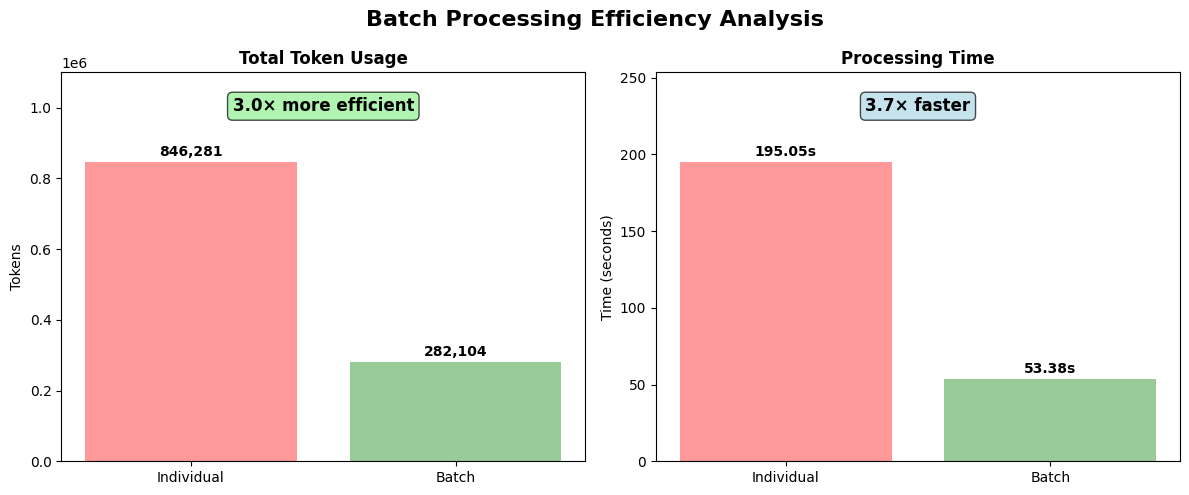

In [ ]:
# Visualization with new module (already imported)

efficiency = comparison_result["efficiency"]
metrics = comparison_result["metrics"]

if efficiency.get("comparison_available"):
    individual_total = metrics["individual"]["tokens"]
    batch_total = metrics["batch"]["tokens"]
    tokens_saved = individual_total - batch_total

    print("📊 EFFICIENCY ANALYSIS:")
    print(f"Individual calls: {metrics['individual']['calls']}")
    print(f"Batch calls: {metrics['batch']['calls']}")
    print(f"Tokens - Individual: {individual_total:,}")
    print(f"Tokens - Batch: {batch_total:,}")
    print(
        f"Tokens saved: {tokens_saved:,} "
        f"({(tokens_saved / individual_total) * 100:.1f}% reduction)",
    )
    print(f"Token efficiency: {efficiency['token_efficiency_ratio']:.1f}x improvement")
    print(f"Time efficiency: {efficiency['time_efficiency']:.1f}x improvement")
    print(f"Meets 3x target: {'✅' if efficiency['meets_target'] else '❌'}")

create_focused_efficiency_visualization(comparison_result)

### Validation Summary

In [ ]:
# Compare theoretical vs actual
theoretical_ratio = len(comparison_questions)
actual_ratio = efficiency["token_efficiency_ratio"]
efficiency_realization = (actual_ratio / theoretical_ratio) * 100

print(f"Theoretical efficiency: ~{theoretical_ratio}x expected")
print(f"Actual efficiency: {actual_ratio:.1f}x achieved")
print(f"Efficiency realization: {efficiency_realization:.1f}% of theoretical maximum")

Theoretical efficiency: ~3× expected
Actual efficiency: 3.0× achieved
Efficiency realization: 100.0% of theoretical maximum


Real-world efficiency closely matches theoretical predictions, validating the token economics model.

---

## Section 5: Research Impact Summary

### Workflow Transformation

**Research workflow transformation:**
| Traditional | AI-Accelerated |
|-------------|----------------|
| Days | Minutes |
| High repetition | 66% cost reduction |
| Manual notes | Structured data |

### Quantified Benefits

From our demonstration:

In [ ]:
# Print final impact metrics
print("📊 WORKFLOW IMPACT:")
print(f"Sources analyzed: {content_summary.total_count}")
print(f"Processing time: {processing_time:.1f} seconds")
print(f"API calls reduced: {traditional_calls} → 1")
print(f"Token efficiency: {actual_ratio:.1f}x improvement")
print(f"Cost reduction: {(tokens_saved / individual_total) * 100:.1f}%")

📊 WORKFLOW IMPACT:
Sources analyzed: 12
Processing time: 63.6 seconds
API calls reduced: 12 → 1
Token efficiency: 3.0× improvement
Cost reduction: 66.7%


### Key Capabilities Demonstrated

1. **Multi-source integration**: PDFs, URLs, videos processed uniformly
2. **Cross-source synthesis**: Analysis across sources, not just individual Q&A
3. **Structured output**: Machine-readable results for research workflows
4. **Efficiency optimization**: 66.7% token reduction with maintained quality
5. **Scalable processing**: Linear scaling with question count

### Research Applications

This approach enables:
- **Rapid literature reviews** for grant writing and research planning
- **Systematic comparisons** across research methodologies
- **Gap analysis** for identifying research opportunities  
- **Knowledge synthesis** for survey papers and reviews

The framework handles diverse academic content types while maintaining research rigor through structured analysis and quality validation.